In [283]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU,Bidirectional
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping

In [284]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,212818400,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,55664000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,28951268,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,26480000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,27913900,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2019-12-31,AMZN,0.715115,92.099998,92.663002,91.611504,92.391998,50130000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7540,2019-12-31,GOOG,0.656211,66.505501,66.900002,66.454247,66.850998,19236000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7541,2019-12-31,GOOGL,0.777357,66.789497,67.032997,66.606499,66.969498,19514000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7542,2019-12-31,MSFT,0.683018,156.770004,157.770004,156.449997,157.699997,18369400,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [285]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [286]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1254, 18)
            Date  p_sentiment       Open       High        Low      Close  \
0     2015-01-02     0.766185  27.847500  27.860001  26.837500  27.332500   
1     2015-01-05     0.846650  27.072500  27.162500  26.352501  26.562500   
2     2015-01-06     0.712894  26.635000  26.857500  26.157499  26.565001   
3     2015-01-07     0.744531  26.799999  27.049999  26.674999  26.937500   
4     2015-01-08     0.769826  27.307501  28.037500  27.174999  27.972500   
...          ...          ...        ...        ...        ...        ...   
1248  2019-12-23     0.761074  70.132500  71.062500  70.092499  71.000000   
1249  2019-12-24     0.775495  71.172501  71.222504  70.730003  71.067497   
1250  2019-12-26     0.742264  71.205002  72.495003  71.175003  72.477501   
1251  2019-12-27     0.768797  72.779999  73.492500  72.029999  72.449997   
1252  2019-12-30     0.746877  72.364998  73.172501  71.305000  72.879997   

         Volume  unrate  psr       m2    dspic      pce    

In [287]:
ticker='TSLA'

In [288]:
df=df_dict
keys=list(df.keys())
keys

['AAPL', 'AMZN', 'GOOG', 'GOOGL', 'MSFT', 'TSLA']

In [289]:
#putting the close column on the last position
dfs=[]
for key in keys:
       dfs.append(df[key][['Date', 'p_sentiment', 'Open', 'High', 'Low',
              'Volume', 'unrate', 'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer',
              'tcs', 'indpro', 'ccpi', 'Close']])

In [290]:
dates=[]
for df in dfs:
    dates.append(pd.to_datetime(df['Date']))

In [291]:

cols=list(dfs[0])[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'Volume',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [292]:
dfs_for_training=[]
for df in dfs:
    dfs_for_training.append(df[cols].astype(float))

In [293]:
scaled_datas=[]
scaler = MinMaxScaler(feature_range=(0, 1))
for df_for_training in dfs_for_training:
    scaled_datas.append(scaler.fit_transform(df_for_training))

In [294]:
print(scaled_data[1])

[0.77183473 0.24678828 0.21948349 0.23172104 0.14147722 1.
 0.6        0.         0.         0.         0.         0.22902763
 0.00178319 0.         0.77924797 0.         0.23121105]


In [295]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [296]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [297]:
Xs=[]
ys=[]
for scaled_data in scaled_datas:
    X=[]
    y=[]
    for i in range(n_past, len(scaled_data) - n_future +1):
        X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
        y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])
    Xs.append(X)
    ys.append(y)

In [298]:
#shape of X_s and y_s
Xss=[]
yss=[]
for X,y in zip(Xs,ys):
    Xss.append(np.array(X))
    yss.append(np.array(y))


In [299]:
print(Xss[0][0])

[[0.73871225 0.10635442 0.09772617 0.08937766 0.27738933 1.
  0.6        0.         0.         0.         0.         0.22902763
  0.00178319 0.         0.77924797 0.         0.09340418]
 [0.91049518 0.09094073 0.08393475 0.0796801  0.35084852 1.
  0.6        0.         0.         0.         0.         0.22902763
  0.00178319 0.         0.77924797 0.         0.0782549 ]
 [0.62494287 0.08223946 0.0779041  0.07578104 0.36086945 1.
  0.6        0.         0.         0.         0.         0.22902763
  0.00178319 0.         0.77924797 0.         0.07830411]
 [0.69248502 0.08552106 0.08171031 0.08612845 0.19055344 1.
  0.6        0.         0.         0.         0.         0.22902763
  0.00178319 0.         0.77924797 0.         0.0856328 ]
 [0.74648586 0.09561458 0.10123579 0.09612595 0.31822548 1.
  0.6        0.         0.         0.         0.         0.22902763
  0.00178319 0.         0.77924797 0.         0.10599579]
 [0.75538668 0.11271878 0.10667326 0.10367409 0.2806702  1.
  0.6     

In [300]:
print(Xss[0][1])

[[0.91049518 0.09094073 0.08393475 0.0796801  0.35084852 1.
  0.6        0.         0.         0.         0.         0.22902763
  0.00178319 0.         0.77924797 0.         0.0782549 ]
 [0.62494287 0.08223946 0.0779041  0.07578104 0.36086945 1.
  0.6        0.         0.         0.         0.         0.22902763
  0.00178319 0.         0.77924797 0.         0.07830411]
 [0.69248502 0.08552106 0.08171031 0.08612845 0.19055344 1.
  0.6        0.         0.         0.         0.         0.22902763
  0.00178319 0.         0.77924797 0.         0.0856328 ]
 [0.74648586 0.09561458 0.10123579 0.09612595 0.31822548 1.
  0.6        0.         0.         0.         0.         0.22902763
  0.00178319 0.         0.77924797 0.         0.10599579]
 [0.75538668 0.11271878 0.10667326 0.10367409 0.2806702  1.
  0.6        0.         0.         0.         0.         0.22902763
  0.00178319 0.         0.77924797 0.         0.10658604]
 [0.91647529 0.11237073 0.10360848 0.09662587 0.25382994 1.
  0.6     

In [301]:
print(yss[0][0])

[0.09778173]


In [302]:
X_trains=[]

X_tests=[]
y_trains=[]
y_tests=[]
size=1125
for X in Xss:
    X_train=X[0:size,:]
    X_test=X[size:,:]
    X_trains.append(X_train)
    X_tests.append(X_test)

for y in yss:
    y_train=y[0:size,:]
    y_test=y[size:,:]
    y_trains.append(y_train)
    y_tests.append(y_test)




#early stopping


Epoch 1/100


12/12 [==============================] - 2s 50ms/step - loss: 0.0121 - val_loss: 0.0880
Epoch 2/100
12/12 [==============================] - 0s 39ms/step - loss: 0.0072 - val_loss: 0.0183
Epoch 3/100
12/12 [==============================] - 0s 38ms/step - loss: 0.0078 - val_loss: 0.0348
Epoch 4/100
12/12 [==============================] - 0s 37ms/step - loss: 0.0014 - val_loss: 0.0275
Epoch 5/100
12/12 [==============================] - 0s 36ms/step - loss: 0.0012 - val_loss: 0.0246
Epoch 6/100
12/12 [==============================] - 0s 38ms/step - loss: 6.9201e-04 - val_loss: 0.0310
Epoch 7/100
12/12 [==============================] - 0s 37ms/step - loss: 3.7415e-04 - val_loss: 0.0269
Epoch 8/100
12/12 [==============================] - 0s 37ms/step - loss: 3.1352e-04 - val_loss: 0.0263
Epoch 9/100
12/12 [==============================] - 0s 38ms/step - loss: 2.6692e-04 - val_loss: 0.0254
Epoch 10/100
12/12 [==============================] - 0s 36ms/step - loss: 2.3921e-04 - val_loss

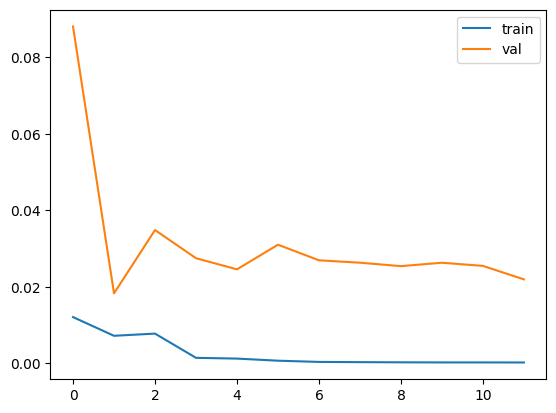

4/4 [==============================] - 0s 5ms/step
mae: 6.877589047293044
(126,)
(126,)


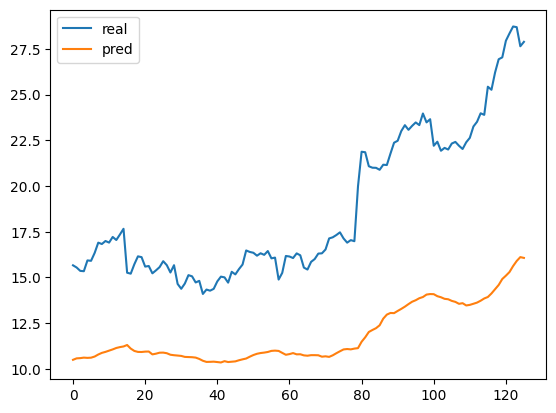

Epoch 1/100
12/12 [==============================] - 2s 50ms/step - loss: 0.0053 - val_loss: 0.0170
Epoch 2/100
12/12 [==============================] - 0s 39ms/step - loss: 0.0083 - val_loss: 0.0049
Epoch 3/100
12/12 [==============================] - 0s 36ms/step - loss: 0.0076 - val_loss: 0.0196
Epoch 4/100
12/12 [==============================] - 0s 37ms/step - loss: 0.0219 - val_loss: 0.0034
Epoch 5/100
12/12 [==============================] - 0s 36ms/step - loss: 0.0029 - val_loss: 0.0232
Epoch 6/100
12/12 [==============================] - 0s 37ms/step - loss: 5.3823e-04 - val_loss: 0.0080
Epoch 7/100
12/12 [==============================] - 0s 37ms/step - loss: 6.8544e-04 - val_loss: 0.0083
Epoch 8/100
12/12 [==============================] - 0s 36ms/step - loss: 4.1958e-04 - val_loss: 0.0056
Epoch 9/100
12/12 [==============================] - 0s 36ms/step - loss: 3.4204e-04 - val_loss: 0.0065
Epoch 10/100
12/12 [==============================] - 0s 36ms/step - loss: 3.0298e-0

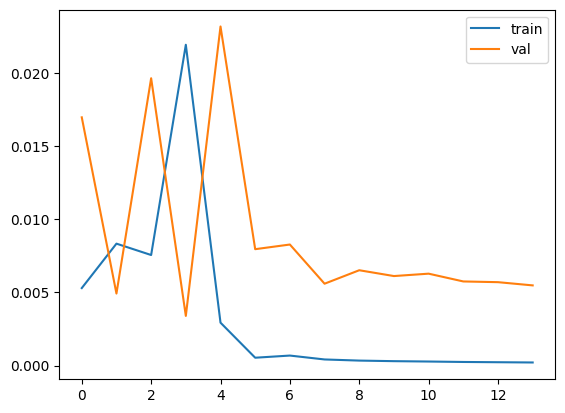

4/4 [==============================] - 0s 4ms/step
mae: 2.190714141077435
(126,)
(126,)


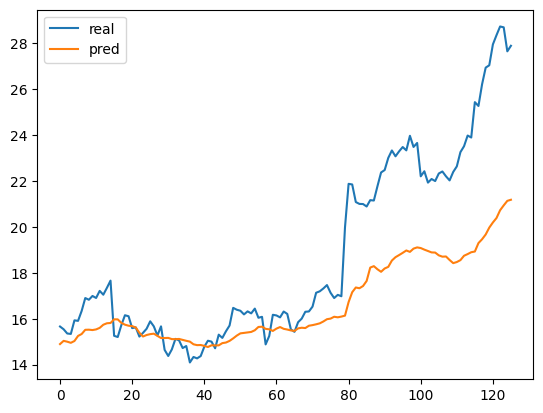

Epoch 1/100
12/12 [==============================] - 2s 48ms/step - loss: 0.0111 - val_loss: 0.0085
Epoch 2/100
12/12 [==============================] - 0s 36ms/step - loss: 0.0438 - val_loss: 0.0477
Epoch 3/100
12/12 [==============================] - 0s 41ms/step - loss: 0.0085 - val_loss: 0.0082
Epoch 4/100
12/12 [==============================] - 0s 38ms/step - loss: 0.0031 - val_loss: 0.0137
Epoch 5/100
12/12 [==============================] - 0s 37ms/step - loss: 0.0011 - val_loss: 0.0144
Epoch 6/100
12/12 [==============================] - 0s 38ms/step - loss: 9.5350e-04 - val_loss: 0.0133
Epoch 7/100
12/12 [==============================] - 0s 37ms/step - loss: 7.3969e-04 - val_loss: 0.0120
Epoch 8/100
12/12 [==============================] - 0s 37ms/step - loss: 6.7511e-04 - val_loss: 0.0120
Epoch 9/100
12/12 [==============================] - 0s 39ms/step - loss: 6.1283e-04 - val_loss: 0.0125
Epoch 10/100
12/12 [==============================] - 0s 36ms/step - loss: 5.6673e-0

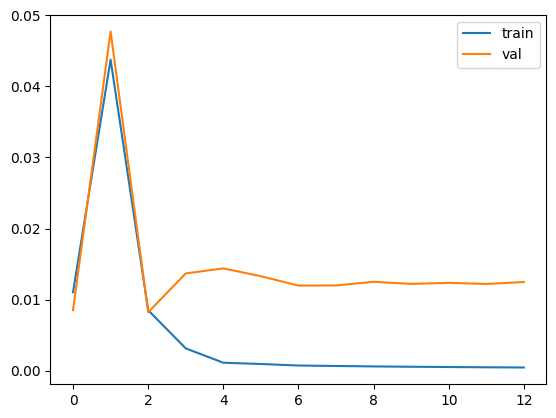

4/4 [==============================] - 0s 4ms/step
mae: 2.223672374268547
(126,)
(126,)


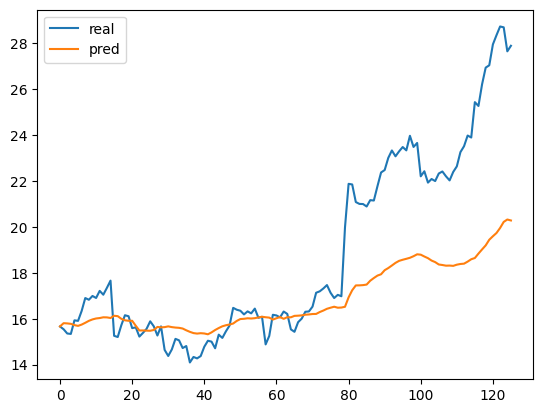

Epoch 1/100
12/12 [==============================] - 2s 58ms/step - loss: 0.0045 - val_loss: 0.0300
Epoch 2/100
12/12 [==============================] - 0s 43ms/step - loss: 0.0209 - val_loss: 0.0084
Epoch 3/100
12/12 [==============================] - 0s 38ms/step - loss: 0.0158 - val_loss: 0.0199
Epoch 4/100
12/12 [==============================] - 0s 36ms/step - loss: 0.0458 - val_loss: 0.0115
Epoch 5/100
12/12 [==============================] - 0s 39ms/step - loss: 0.0055 - val_loss: 0.0193
Epoch 6/100
12/12 [==============================] - 0s 36ms/step - loss: 0.0027 - val_loss: 0.0086
Epoch 7/100
12/12 [==============================] - 0s 37ms/step - loss: 0.0017 - val_loss: 0.0048
Epoch 8/100
12/12 [==============================] - 0s 37ms/step - loss: 9.9064e-04 - val_loss: 0.0050
Epoch 9/100
12/12 [==============================] - 0s 38ms/step - loss: 8.8194e-04 - val_loss: 0.0043
Epoch 10/100
12/12 [==============================] - 0s 38ms/step - loss: 8.0092e-04 - val_

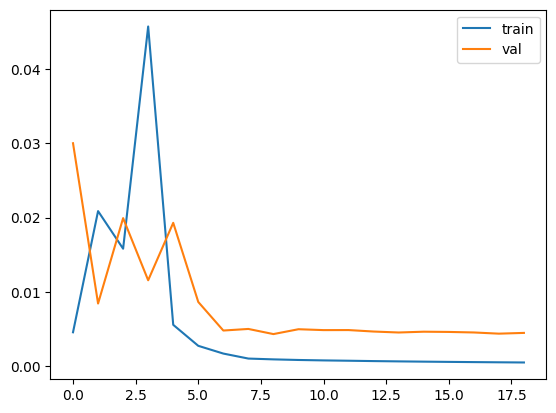

4/4 [==============================] - 0s 3ms/step
mae: 2.0561748391452364
(126,)
(126,)


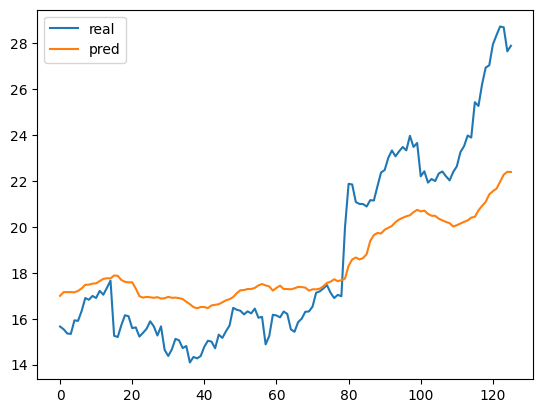

Epoch 1/100
12/12 [==============================] - 144s 11s/step - loss: 0.0017 - val_loss: 0.0079
Epoch 2/100
12/12 [==============================] - 4s 325ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 3/100


KeyboardInterrupt: 

In [303]:
tscv = TimeSeriesSplit(n_splits=2)
for X_Train in X_trains,y_trains):

    maes=[]
    y_test=np.repeat(y_test,X_train.shape[2],axis=1)
    y_test=scaler.inverse_transform(y_test)[:,-1] 
    for train_index, val_index in tscv.split(X_train):
            early_stop=EarlyStopping(monitor='val_loss',patience=10)
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            model=Sequential()
            model.add(Bidirectional(GRU(256, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False)))
            model.add(Dense(y_train.shape[1]))
            model.compile(optimizer='adam',loss='mse')

            history=model.fit(X_train,y_train,epochs=100,validation_data=(X_val,y_val),shuffle=False, callbacks=[early_stop])
            plt.plot(history.history['loss'],label='train')
            plt.plot(history.history['val_loss'],label='val')
            plt.legend()
            plt.show()
            y_pred=model.predict(X_test)
            y_pred.shape

            pred=np.repeat(y_pred,X_train.shape[2],axis=1)

            pred=scaler.inverse_transform(pred)[:,-1]

            mae=np.mean(np.abs(pred-y_test))
            maes.append(mae)
            print('mae:',mae)

            print(pred.shape)
            print(y_test.shape)

            #plotting the results
            plt.plot(y_test, label='real')
            plt.plot(pred, label='pred') 
            plt.legend()
            plt.show()


In [ ]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_21 (Bidirect  (None, 128)               31872     
 ional)                                                          
                                                                 
 dense_21 (Dense)            (None, 1)                 129       
                                                                 
Total params: 32001 (125.00 KB)
Trainable params: 32001 (125.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
average_mae=np.mean(maes)
print('average mae:',average_mae)

average mae: 3.6926336184676036
